# Model Analysis
Now that we've trained a few different models, let's look at the performance of different hyperparameters to see where we should go from here.

In [81]:
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
%matplotlib inline

def plot_files(files):
    offsets = [1] * len(files)

    labels_and_results = []
    color_map = list(mcolors.TABLEAU_COLORS.keys())

    for (label, file) in files:
        with open(file, 'r') as f:
            result = json.load(f)
            labels_and_results.append((label, result))


    fig, axs = plt.subplots(ncols=2, figsize=(10, 4))

    for i in range(len(files)):
        label = labels_and_results[i][0]
        result = labels_and_results[i][1]

        num_data_points = len(result['elapsed_times'])
        epoch_start = offsets[i]
        epoch_range = list(range(epoch_start, epoch_start + num_data_points))

        axs[0].plot(epoch_range, result['dev_losses'], color_map[i], linestyle='--', label=label + '_dev')
        axs[0].plot(epoch_range, result['train_losses'], color_map[i], label=label + '_train')

        axs[1].plot(epoch_range, result['dev_accu_pcts'], color_map[i], linestyle='--')
        axs[1].plot(epoch_range, result['train_accu_pcts'], color_map[i])

    axs[0].set_title('Epoch vs Loss')
    axs[1].set_title('Epoch vs Accuracy')
    axs[0].xaxis.set_major_locator(mticker.MultipleLocator(5))
    axs[1].xaxis.set_major_locator(mticker.MultipleLocator(5))
    fig.legend(bbox_to_anchor=(1.0, 1), loc="upper left")

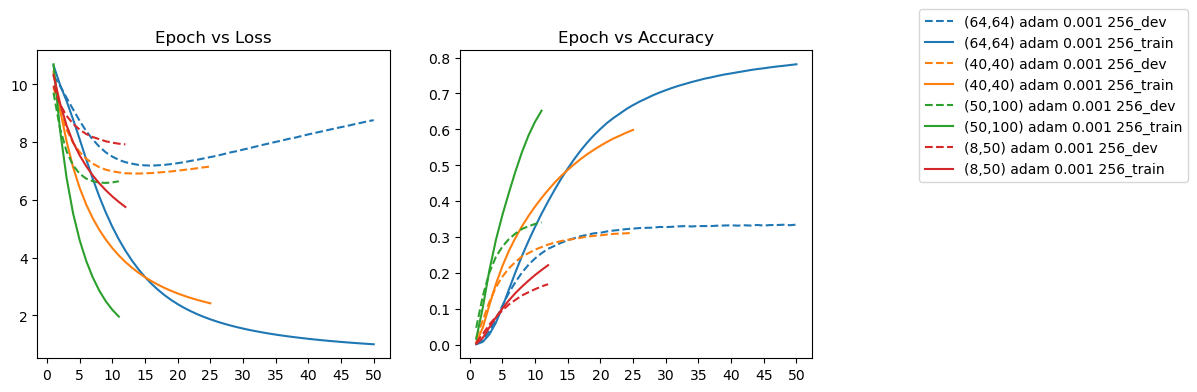

In [83]:
files = [
    ('(64,64) adam 0.001 256', 'training_results/20230321-023258-training/training-results.json'), # 64,64 - adam, 0.001, 256
    ('(40,40) adam 0.001 256', 'training_results/20230321-080031-training/training-results.json'), # 40,40 - adam, 0.001, 256,
    ('(50,100) adam 0.001 256', 'training_results/20230321-100932-training/training-results.json'), # 50, 100 - adam, 0.001, 256,
    ('(8,50) adam 0.001 256', 'training_results/20230321-105038-training/training-results.json'), # 8, 50 - adam, 0.001, 256,
]
plot_files(files)

So it seems that 50 dimensions and 100 neurons is our best setup so far. Interestingly 40/40 and 64/64 ended up with similar results just different training times. Leads me to believe that the ratio of embedding dimensions to neuron count is important.

## Ignore Unknown Token
We represent unknown tokens with index 0 in our answers vocabulary, but this is not something that would actually be recommended. We can ignore this when calculating loss by using the `ignore_index` parameter. Let's try that and see the results.

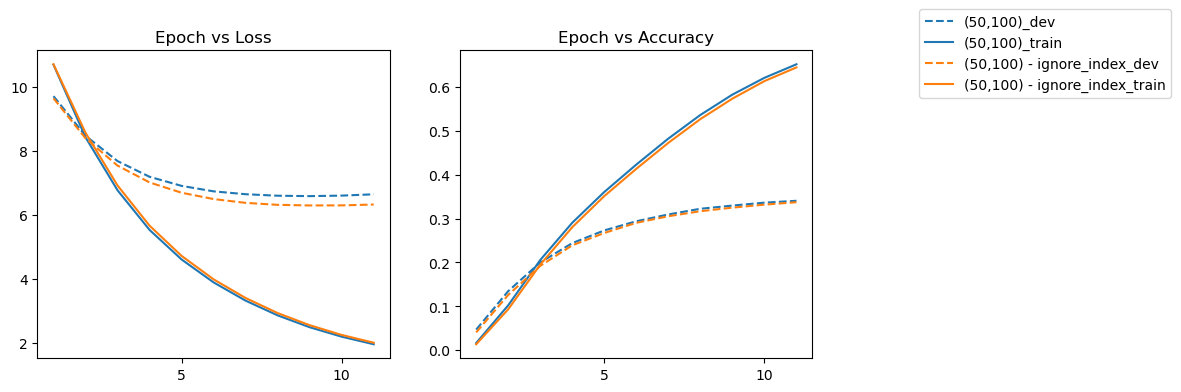

In [84]:
files = [
    ('(50,100)', 'training_results/20230321-100932-training/training-results.json'), # 50, 100 - adam, 0.001, 256,
    ('(50,100) - ignore_index', 'training_results/20230321-113214-training/training-results.json'), # 50, 100 - adam, 0.001, 256, - with igonre_index
]
plot_files(files)

No significant difference here. Let's keep this parameter for now since it "feels" like the right thing to do.

## Weight Decay
We can "gravitate" our output weights to be close to zero by adding a weight decay to our optimizer. It seems like the easiest way to do this in PyTorch is to use the [https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html] optimizer. 

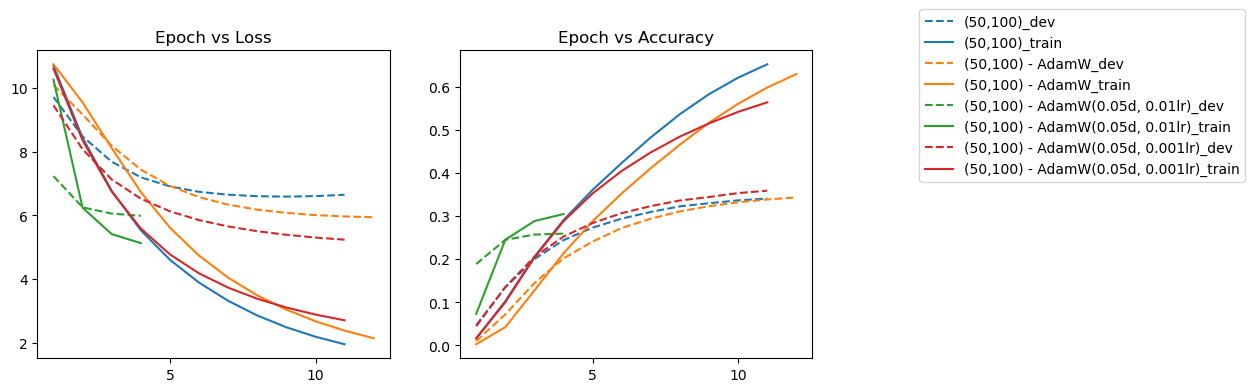

In [85]:
files = [
    ('(50,100)', 'training_results/20230321-100932-training/training-results.json'), # 50, 100 - adam, 0.001, 256,
    ('(50,100) - AdamW', 'training_results/20230321-121519-training/training-results.json'), # 50, 100 - adamW (default), 0.001, 256,
    ('(50,100) - AdamW(0.05d, 0.01lr)', 'training_results/20230321-125918-training/training-results.json'), # 50, 100 - adamW (0.05 decay, 0.01 LR), 0.01, 256,
    ('(50,100) - AdamW(0.05d, 0.001lr)', 'training_results/20230321-131534-training/training-results.json'), # 50, 100 - adamW (0.05 decay, 0.001 LR), 0.001, 256,
]
plot_files(files)

There's definitely some improvement here as we add decay. Additional experimentation is need to determine optimal values, but for now let's take another look at the size of or network. We seem to be underfitting and networks that had a higer ratio of hidden neurons to embedding dimensions have seen to perform better. Let's test out some larger networks.

## Larger Networks
Let's run some experiments to figure out what sizes our embedding hidden layers should be:

Test embedding dimensions from 2^3 --> 2^11:
```
python trainer/task.py --batch-size 128 --num-epochs 20 --device cpu --learning-rate 0.001 --weight-decay 0.01 --embedding-dimensions 8 --hidden-layer-size 512 --output-folder 8d512n --model-name none
python trainer/task.py --batch-size 128 --num-epochs 20 --device cpu --learning-rate 0.001 --weight-decay 0.01 --embedding-dimensions 16 --hidden-layer-size 512 --output-folder 16d512n --model-name none
python trainer/task.py --batch-size 128 --num-epochs 20 --device cpu --learning-rate 0.001 --weight-decay 0.01 --embedding-dimensions 32 --hidden-layer-size 512 --output-folder 32d512n --model-name none
python trainer/task.py --batch-size 128 --num-epochs 20 --device cpu --learning-rate 0.001 --weight-decay 0.01 --embedding-dimensions 64 --hidden-layer-size 512 --output-folder 64d512n --model-name none
python trainer/task.py --batch-size 128 --num-epochs 20 --device cpu --learning-rate 0.001 --weight-decay 0.01 --embedding-dimensions 128 --hidden-layer-size 512 --output-folder 128d512n --model-name none
python trainer/task.py --batch-size 128 --num-epochs 20 --device cpu --learning-rate 0.001 --weight-decay 0.01 --embedding-dimensions 256 --hidden-layer-size 512 --output-folder 256d512n --model-name none
python trainer/task.py --batch-size 128 --num-epochs 20 --device cpu --learning-rate 0.001 --weight-decay 0.01 --embedding-dimensions 512 --hidden-layer-size 512 --output-folder 512d512n --model-name none
python trainer/task.py --batch-size 128 --num-epochs 20 --device cpu --learning-rate 0.001 --weight-decay 0.01 --embedding-dimensions 1024 --hidden-layer-size 512 --output-folder 1024d512n --model-name none
python trainer/task.py --batch-size 128 --num-epochs 20 --device cpu --learning-rate 0.001 --weight-decay 0.01 --embedding-dimensions 2048 --hidden-layer-size 512 --output-folder 2048d512n --model-name none

```

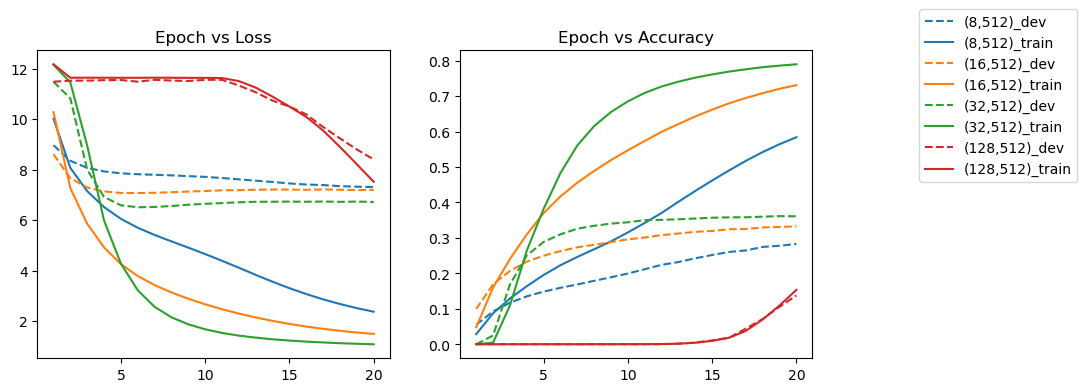

In [177]:
files = [
    ('(8,512)', 'training_results/8d512n/training-results.json'),
    ('(16,512)', 'training_results/16d512n/training-results.json'),
    ('(32,512)', 'training_results/32d512n/training-results.json'),
    #('(64,512)', 'training_results/64d512n/training-results.json'), # --  on cuda
    ('(128,512)', 'training_results/128d512n/training-results.json'), # --  on cuda
    #('(256,512)', 'training_results/256d512n/training-results.json'),
    #('(512,512)', 'training_results/512d512n/training-results.json'),
    #('(1024,512)', 'training_results/1024d512n/training-results.json'),
    #('(2048,512)', 'training_results/2048d512n/training-results.json')
]
plot_files(files)

Test hidden layers from 2^4 --> 2^12:
```
python trainer/task.py --batch-size 128 --num-epochs 20 --device mps --learning-rate 0.001 --weight-decay 0.01 --embedding-dimensions 50 --hidden-layer-size 16 --output-folder 50d16n --model-name none
python trainer/task.py --batch-size 128 --num-epochs 20 --device mps --learning-rate 0.001 --weight-decay 0.01 --embedding-dimensions 50 --hidden-layer-size 32 --output-folder 50d32n --model-name none
python trainer/task.py --batch-size 128 --num-epochs 20 --device mps --learning-rate 0.001 --weight-decay 0.01 --embedding-dimensions 50 --hidden-layer-size 64 --output-folder 50d64n --model-name none
python trainer/task.py --batch-size 128 --num-epochs 20 --device mps --learning-rate 0.001 --weight-decay 0.01 --embedding-dimensions 50 --hidden-layer-size 128 --output-folder 50d128n --model-name none
python trainer/task.py --batch-size 128 --num-epochs 20 --device mps --learning-rate 0.001 --weight-decay 0.01 --embedding-dimensions 50 --hidden-layer-size 256 --output-folder 50d256n --model-name none
python trainer/task.py --batch-size 128 --num-epochs 20 --device mps --learning-rate 0.001 --weight-decay 0.01 --embedding-dimensions 50 --hidden-layer-size 512 --output-folder 50d512n --model-name none
python trainer/task.py --batch-size 128 --num-epochs 20 --device mps --learning-rate 0.001 --weight-decay 0.01 --embedding-dimensions 50 --hidden-layer-size 1024 --output-folder 50d1024n --model-name none
python trainer/task.py --batch-size 128 --num-epochs 20 --device mps --learning-rate 0.001 --weight-decay 0.01 --embedding-dimensions 50 --hidden-layer-size 2048 --output-folder 50d2048n --model-name none
python trainer/task.py --batch-size 128 --num-epochs 20 --device mps --learning-rate 0.001 --weight-decay 0.01 --embedding-dimensions 50 --hidden-layer-size 4096 --output-folder 50d4096n --model-name none
```

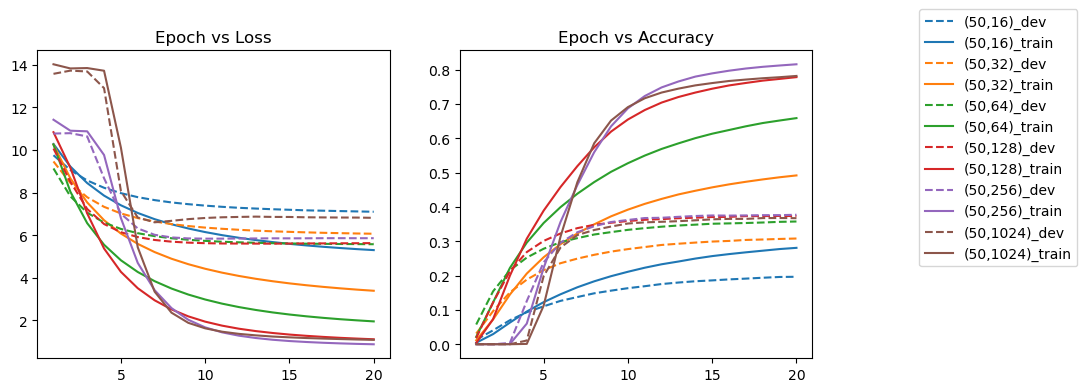

In [160]:
files = [
    ('(50,16)', 'training_results/50d16n/training-results.json'),
    ('(50,32)', 'training_results/50d32n/training-results.json'),
    ('(50,64)', 'training_results/50d64n/training-results.json'),
    ('(50,128)', 'training_results/50d128n/training-results.json'),
    ('(50,256)', 'training_results/50d256n/training-results.json'),
    #('(50,512)', 'training_results/50d512n/training-results.json'),
    ('(50,1024)', 'training_results/50d1024n/training-results.json'), # --  on cuda
]
plot_files(files)

# Random Exploration
Just some random networks that I tried without being too methodical.

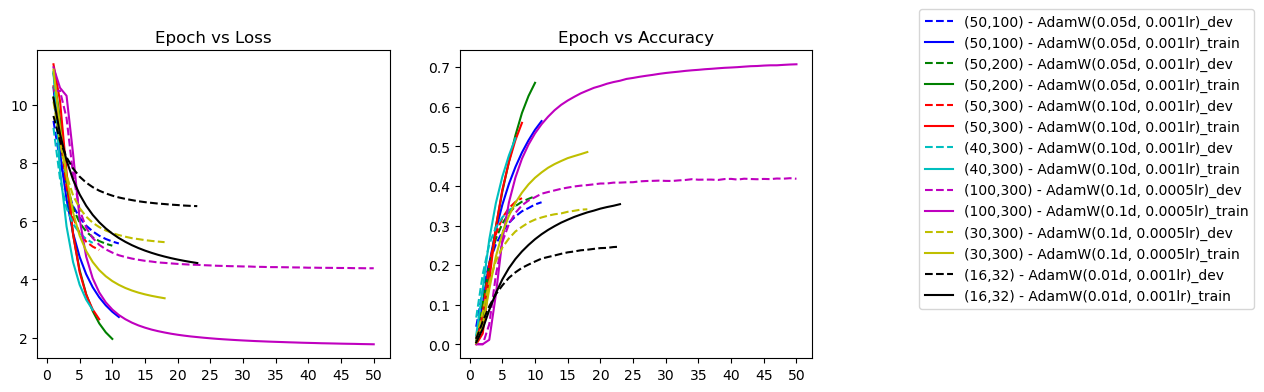

In [23]:
files = [
    ('(50,100) - AdamW(0.05d, 0.001lr)', 'training_results/20230321-131534-training/training-results.json'), # 50, 100 - adamW (0.05 decay, 0.001 LR), 0.001, 256,
    ('(50,200) - AdamW(0.05d, 0.001lr)', 'training_results/20230321-135830-training/training-results.json'), # 50, 200 - adamW (0.05 decay, 0.001 LR), 0.001, 256,
    ('(50,300) - AdamW(0.10d, 0.001lr)', 'training_results/20230321-144005-training/training-results.json'), # 50, 300 - adamW (0.10 decay, 0.001 LR), 0.001, 256,
    ('(40,300) - AdamW(0.10d, 0.001lr)', 'training_results/20230321-152345-training/training-results.json'), # 40, 300 - adamW (0.10 decay, 0.001 LR), 0.001, 256,
    #('(100,300) - AdamW(0.001d, 0.001lr)', 'training_results/20230321-155612-training/training-results.json'), # 100, 300 - adamW (0.001 decay, 0.001 LR), 0.001, 256,
    ('(100,300) - AdamW(0.1d, 0.0005lr)', 'training_results/20230321-212618-training/training-results.json'), # 100, 300 - adamW (0.100 decay, 0.0005 LR), 0.0005, 128,
    ('(30,300) - AdamW(0.1d, 0.0005lr)', 'training_results/20230322-063005-training/training-results.json'), # 100, 300 - adamW (0.100 decay, 0.0005 LR), 0.0005, 128,
    ('(16,32) - AdamW(0.01d, 0.001lr)', 'training_results/20230322-104859-training/training-results.json'), # 16, 32 - adamW (0.01 decay, 0.001 LR), 0.001, 128,

    
    #('(100,200) - 2 Layer(0.1d, 0.001lr)', 'training_results/20230321-212210-training/training-results.json'), # 100, 200 - 2 layer (0.100 decay, 0.001 LR), 0.001, 128,
]
plot_files(files)

## Summary
So it looks like our model is not working particularily well regadless of size. Let's try some things on a small model to see what we can improve.
```
python trainer/task.py --batch-size 128 --num-epochs 10 --device cpu --learning-rate 0.001 --weight-decay 0.01 --embedding-dimensions 50 --hidden-layer-size 64 --output-folder 50d64n-exp5 --model-name none
```

Add `padding_idx` took training from 157.16s per epoch to 147.86s


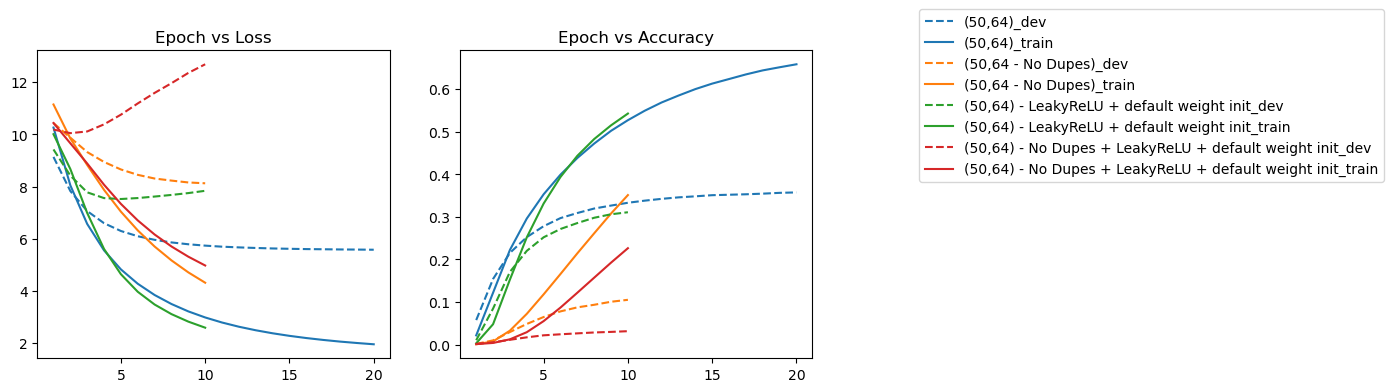

In [221]:
files = [
    ('(50,64)', 'training_results/50d64n/training-results.json'),
    ('(50,64 - No Dupes)', 'training_results/50d64n-exp5/training-results.json'),
    ('(50,64) - LeakyReLU + default weight init', 'training_results/8d16n-exp3/training-results.json'),
    ('(50,64) - No Dupes + LeakyReLU + default weight init', 'training_results/8d16n-exp4/training-results.json'), # new dataset
]
plot_files(files)

Well, this isn't a great sign -- removing the duplicates from our dataset means that we basically aren't learning anything about the test set. Let's go back to the drawing board in the next notebook.